In [4]:
import pandas as pd
from google.cloud import bigquery
from google.cloud.client import service_account

import matplotlib.pyplot as plt
import numpy as np

In [5]:
import datetime

In [6]:
# path_to_file = '/Users/vasikos/Documents/working_notebooks/client.json'

# credentials = service_account.Credentials.from_service_account_file(path_to_file,
#                                                                     scopes=["https://www.googleapis.com/auth/cloud-platform"])
# client = bigquery.Client(credentials=credentials, project=credentials.project_id)
# query = '''
# SELECT 
#     orde.id as order_id
#     , orde.customer_id
#     , orde.customer_name
#     , orde.branch_id
#     , orde.delivered_at
#     , orde.committed_time
#     , orde.order_status
#     , orde.order_type
#     , orde.delivery_type
#     , orde.total
#     , orde.created_at
#     , orde.order_status_delivered_time
#     , orde.order_status_cancelled_time
#     , orde.order_status_cancelled_by_merchant_time
#     , orde.order_status_cancelled_by_customer_time
#     , orde.order_status_declined_time
#     , branch.lat as branch_lat
#     , branch.lng as branch_lon
#     , shipping.lat as shipping_lat
#     , shipping.lng as shipping_lon
# FROM
#     (
#         SELECT *
#         FROM snoonu-rudderstack.snoonu_dwh.dwd_snu_trd_core_df
#         WHERE DATE(ds) = CURRENT_DATE('Asia/Qatar') - 1
#     ) as orde
#     JOIN 
#     (
#         SELECT *
#         FROM snoonu-rudderstack.snoonu_dwh.dwd_snu_shipping_address_df
#         WHERE DATE(ds) = CURRENT_DATE('Asia/Qatar') - 1
#     ) as shipping
#     ON shipping.OrderId = orde.id
#     JOIN
#     (
#         SELECT *
#         FROM snoonu-rudderstack.snoonu_dwh.dwd_snu_order_branch_df
#         WHERE DATE(ds) = CURRENT_DATE('Asia/Qatar') - 1
#     ) as branch
#     ON branch.order_id = orde.id
# '''
# query_job = client.query(query)
# data = query_job.result().to_dataframe()
# data.to_pickle('data.pkl')

In [7]:
data = pd.read_pickle('data.pkl')

In [64]:
data['rta1'] = (data['delivered_at'] - data['created_at']).dt.seconds
data[['delivered_at', 'order_status_delivered_time']]

delivered_at      order_status_delivered_time
0                                    NaT                              NaT
35                                   NaT                              NaT
36                                   NaT                              NaT
37                                   NaT                              NaT
38                                   NaT                              NaT
...                                  ...                              ...
6104910                              NaT                              NaT
6104912                              NaT                              NaT
6104875 2022-08-16 23:42:21.682962+00:00 2022-08-16 23:42:21.701229+00:00
6105023 2022-08-16 23:56:15.260059+00:00 2022-08-16 23:56:15.279882+00:00
6105098 2022-08-16 23:54:57.138728+00:00 2022-08-16 23:54:57.901672+00:00

[6105367 rows x 2 columns]

0.743459811670617

In [8]:
def haversine(df, lat1, lng1, lat2, lng2):
    lat1 = np.deg2rad(df[lat1])
    lon1 = np.deg2rad(df[lng1])
    lat2 = np.deg2rad(df[lat2])
    lon2 = np.deg2rad(df[lng2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

data = data.sort_values(['customer_id', 'created_at']).reset_index(drop=True)

data['eta'] = (data['committed_time'] - data['created_at']).dt.seconds
data['rta'] = (data['order_status_delivered_time'] - data['created_at']).dt.seconds
data['delay'] = data['rta'] - data['eta']
data['p_delay'] = data['delay'] / data['eta']

data['distance'] = haversine(data, 'branch_lat', 'branch_lon', 'shipping_lat', 'shipping_lon')

In [9]:
CHURN_DEPTH = 30 # days

ACTIVATION_KEY = ['customer_id', 'created_at']
ACTIVATION_DATA = ['distance', 'eta', 'rta', 'delay', 'p_delay']

tmp = data[ACTIVATION_KEY].diff()
not_same_customer = (tmp['customer_id'] != 0)
more_than_churn = (tmp['created_at'] > pd.to_timedelta(CHURN_DEPTH, 'D'))
new_activation = (not_same_customer | more_than_churn).fillna(True)
data['is_activation'] = new_activation

tmp = data[ACTIVATION_KEY].diff(-1)
next_customer_same = (tmp['customer_id'] == 0).fillna(False)
next_order_later_churn = (tmp['created_at'] < - pd.to_timedelta(CHURN_DEPTH, 'D')).fillna(False)
next_order_earlier_churn = (data['created_at'] < pd.to_datetime(datetime.datetime.now(), utc=True) - pd.to_timedelta(CHURN_DEPTH, 'D')).fillna(False)
churn = (next_customer_same & next_order_later_churn) | (~next_customer_same & next_order_earlier_churn)
data['churn'] = churn

In [10]:
activations = data[data['is_activation']][ACTIVATION_DATA + ACTIVATION_KEY]
activations['activation_time'] = activations['created_at']

data = pd.merge_asof(
    data.sort_values('created_at'),
    activations.sort_values('created_at'),
    on='created_at',
    by='customer_id',
    suffixes=('', '_activation')
    )

In [12]:
data['relative_day'] = (data['created_at'].dt.date - data['activation_time'].dt.date).dt.days
data['activation_cohort'] = data['activation_time'].dt.to_period('M')

/Users/vasikos/.pyenv/versions/3.10.3/envs/py3.10/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [13]:
data = data.sort_values(['customer_id', 'created_at'])

data['next_order_in'] = data['created_at'].diff()
next_same_activation = (data['customer_id'].diff(-1) == 0).fillna(False) & \
                       (data['activation_cohort'] == data['activation_cohort'].shift(-1)).fillna(False)
print(data['next_order_in'].isna().mean())
data.loc[~next_same_activation, 'next_order_in'] = pd.NA
print(data['next_order_in'].isna().mean())
data.loc[data['churn'], 'next_order_in'] = pd.NA
print(data['next_order_in'].isna().mean())
data['next_order_in'] = data['next_order_in'].dt.total_seconds()

1.6379031760089115e-07
0.12074179979680173
0.12074949794172897


# Try to reproduce Ilya's graphs

## Churn vs. Delay

In [14]:
mask_6m = (data['activation_cohort'] >= '2022-01-01') & (data['activation_cohort'] < '2022-07-01') # Jan-Jun
mask_2m = (data['activation_cohort'] >= '2022-05-01') & (data['activation_cohort'] < '2022-07-01') # May+Jun

Text(0.5, 1.0, 'Probability of Churn vs Delay (minute) for different activation cohorts')

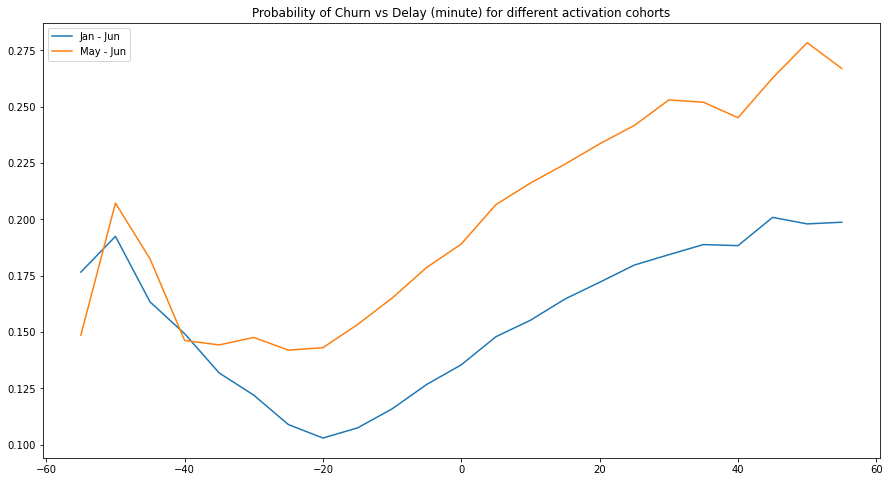

In [15]:
ROUND_N_MINUTES = 5

def plot_churn_delay(data, label):
    data['delay_round'] = data['delay'] // 60 // ROUND_N_MINUTES * ROUND_N_MINUTES
    data_gr = data.groupby('delay_round')['churn'].mean()
    m = (data_gr.index > -60) & (data_gr.index < 60)
    plt.plot(data_gr[m].index, data_gr[m], label=label)

plt.figure(figsize=(15, 8))
plot_churn_delay(data[mask_6m].copy(), 'Jan - Jun')
plot_churn_delay(data[mask_2m].copy(), 'May - Jun')
plt.legend()
plt.title('Probability of Churn vs Delay (minute) for different activation cohorts')

## Time to next order vs Delay

Text(0.5, 1.0, 'Mean Time-to-Next-Order (days) vs Delay (minute) for different activation cohorts')

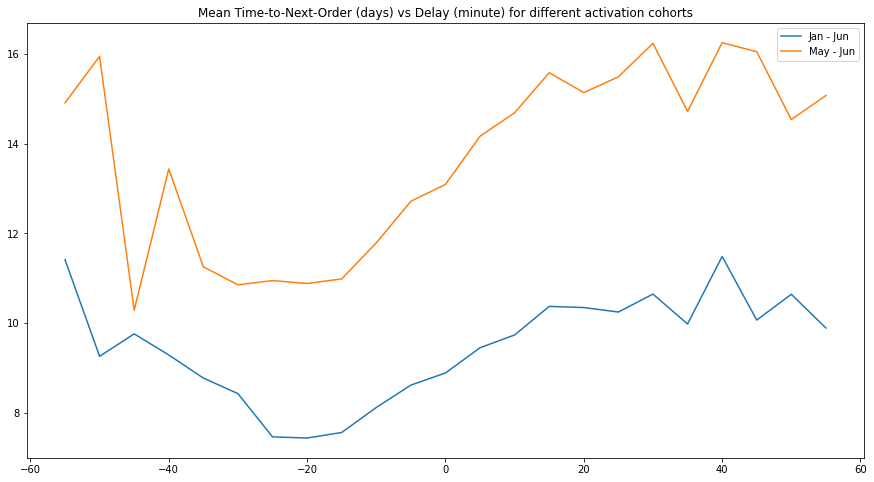

In [18]:
ROUND_N_MINUTES = 5

def plot_TTNO_delay(data, label):
    data['delay_round'] = data['delay'] // 60 // ROUND_N_MINUTES * ROUND_N_MINUTES
    data_gr = data.groupby('delay_round')['next_order_in'].mean() / 60 / 60 / 24
    # data_gr = data.groupby('delay_round')['next_order_in'].count()
    m = (data_gr.index > -60) & (data_gr.index < 60)
    plt.plot(data_gr[m].index, data_gr[m], label=label)

plt.figure(figsize=(15, 8))
plot_TTNO_delay(data[mask_6m].copy(), 'Jan - Jun')
plot_TTNO_delay(data[mask_2m].copy(), 'May - Jun')
plt.legend()
plt.title('Mean Time-to-Next-Order (days) vs Delay (minute) for different activation cohorts')

In [21]:
data_small = data.head(100)

In [42]:
data_small.groupby(['has', 'day'])['customer_id'].nunique().unstack()

day    0    179  182  187  193  201  207  217  218  219  ...  270  282  295  \
has                                                      ...                  
False    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   

day    365  499  500  501  504  505  506  
has                                       
False    1    1    1    1    1    1    1  

[1 rows x 27 columns]

Text(0.5, 1.0, 'Retention in July for users activated in June by presense of delay (> 10 min)')

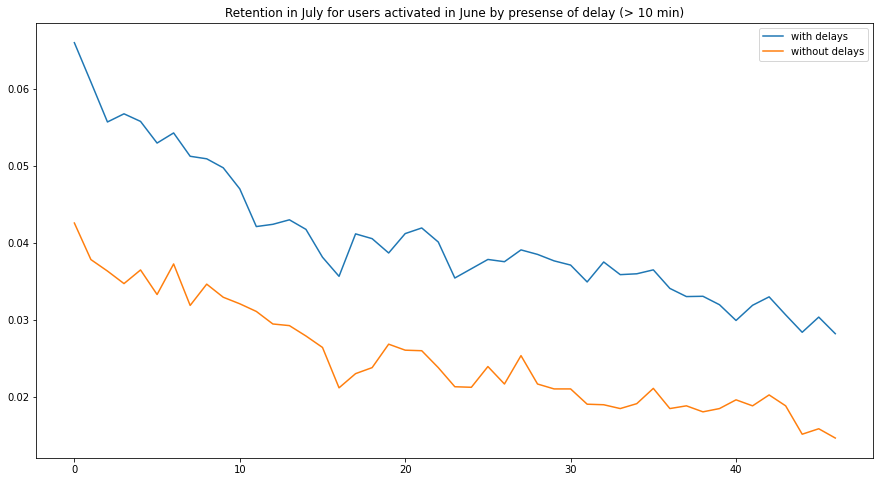

In [72]:
def plot_jun_delay_cohorts(data):
    mask_jun_orders = data['created_at'].between('2022-06-01', '2022-07-01', inclusive='left')
    cust = data[mask_jun_orders].groupby('customer_id')['delay'].max()
    cust_w_delays = cust > 10
    data['has_delays'] = data['customer_id'].isin(cust[cust_w_delays].index)
    mask_jul_orders = data['created_at'].between('2022-07-01', '2022-09-01', inclusive='left')
    data['order_day'] = (data['created_at'] - pd.to_datetime('2022-07-01', utc=True)).dt.days
    # data['order_day'] = (data['created_at']).dt.date
    data_gr = data[mask_jul_orders].groupby(['order_day', 'has_delays'])['customer_id'].nunique().unstack()
    plt.plot(data_gr.index, data_gr[True] / sum(cust_w_delays), label='with delays')
    plt.plot(data_gr.index, data_gr[False] / sum(~cust_w_delays), label='without delays')

mask_jun = (data['activation_cohort'] >= '2022-06-01') & (data['activation_cohort'] < '2022-07-01')

plt.figure(figsize=(15, 8))
plot_jun_delay_cohorts(data[mask_jun].copy())
plt.legend()
plt.title('Retention in July for users activated in June by presense of delay (> 10 min)')

## Now we end reproducing and start seperate research

32939 41438


Text(0.5, 1.0, 'Retention in July for users activated in June by presense of delay (> 10 min)')

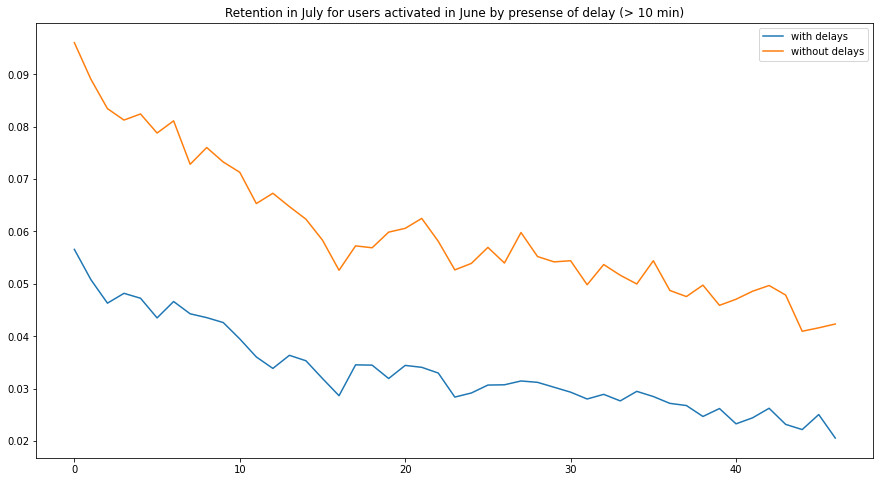

In [60]:
def plot_jun_delay_cohorts1(data):
    data['has_delays'] = data['delay_activation'] > 10

    mask_jul_orders = data['created_at'].between('2022-07-01', '2022-09-01', inclusive='left')
    
    data['order_day'] = (data['created_at'] - pd.to_datetime('2022-07-01', utc=True)).dt.days

    data_gr = data[mask_jul_orders].groupby(['order_day', 'has_delays'])['customer_id'].nunique().unstack()
    cust_delay = data[data['delay_activation'] > 10]['customer_id'].nunique()
    cust_no_delay = data[data['delay_activation'] <= 10]['customer_id'].nunique()
    print(cust_delay +cust_no_delay, data['customer_id'].nunique())
    # assert cust_delay + cust_no_delay == data['customer_id'].nunique()
    plt.plot(data_gr.index, data_gr[True] / cust_delay, label='with delays')
    plt.plot(data_gr.index, data_gr[False] / cust_no_delay, label='without delays')

plt.figure(figsize=(15, 8))
plot_jun_delay_cohorts1(data[mask_jun].copy())
plt.legend()
plt.title('Retention in July for users activated in June by presense of delay (> 10 min)')

In [90]:
tmp

cg
(-inf, -600.0]    2700
(-600.0, 0.0]     7465
(0.0, 600.0]      8509
(600.0, inf]      5880
Name: customer_id, dtype: int64

Text(0.5, 1.0, 'Retention in orders by activation cohorts')

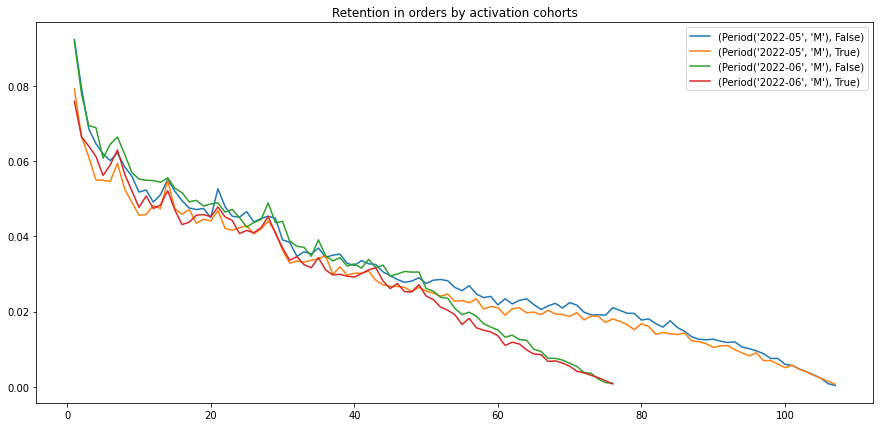

In [101]:
data['big_activ_delay'] = data['delay_activation'] > 10
data['cohort_delay'] = data[['activation_cohort', 'big_activ_delay']].apply(tuple, axis=1)

ret_df = data[mask_2m].groupby(['relative_day', 'cohort_delay'])['customer_id'].nunique().unstack()
ret_df = ret_df.loc[1:]



tmp = data[mask_2m].groupby(['cohort_delay'])['customer_id'].nunique()
ret_df = ret_df / tmp

plt.figure(figsize=(15, 7))
for c in ret_df.columns:
    plt.plot(ret_df.index, ret_df[c], label=c)
plt.legend()
plt.title('Retention in orders by activation cohorts')

Text(0.5, 1.0, 'Retention in orders by activation cohorts')

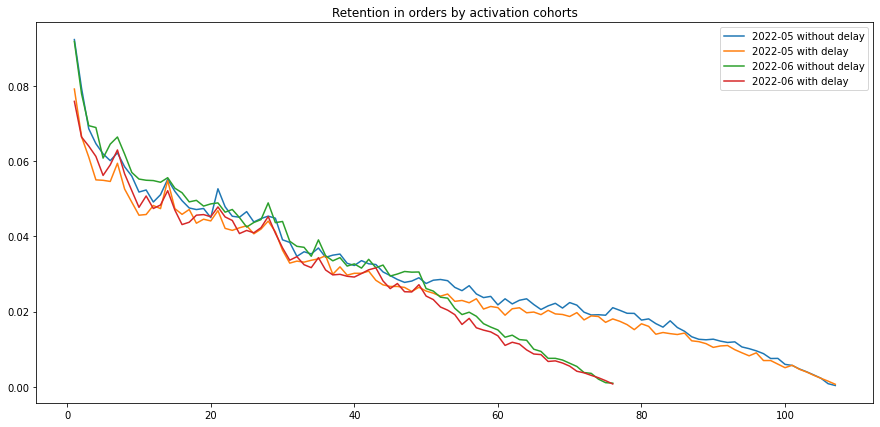

In [106]:
plt.figure(figsize=(15, 7))
for c in ret_df.columns:
    plt.plot(ret_df.index, ret_df[c], label=str(c[0]) + (' with delay' if c[1] else ' without delay'))
plt.legend()
plt.title('Retention in orders by activation cohorts')

Text(0.5, 1.0, 'Retention in orders by activation cohorts')

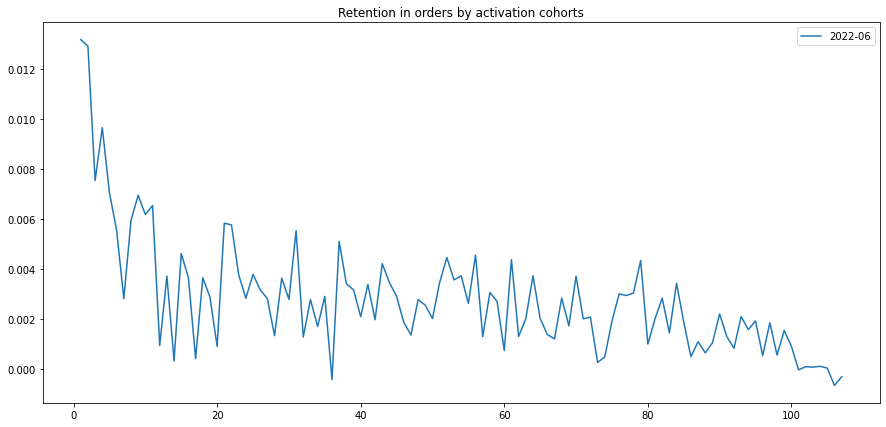

In [115]:
plt.figure(figsize=(15, 7))

plt.plot(ret_df.index, ret_df[(pd.Period('2022-05'), False)] - ret_df[(pd.Period('2022-05'), True)], label=str(c[0]))
# plt.plot(ret_df.index, ret_df[c], label=str(c[0]))
plt.legend()
plt.title('Retention in orders by activation cohorts')

In [129]:
print((ret_df[(pd.Period('2022-05'), False)] - ret_df[(pd.Period('2022-05'), True)]).sum() / ret_df[(pd.Period('2022-05'), False)].sum())
print(ret_df[(pd.Period('2022-05'), False)].sum())

0.09325774483403325
3.2011840062111796


In [132]:
coh = data['activation_cohort'] == pd.Period('2022-05')
data[coh].groupby('big_activ_delay')['customer_id'].nunique()

big_activ_delay
False    30912
True     26276
Name: customer_id, dtype: int64

In [127]:
(ret_df[(pd.Period('2022-05'), False)] - ret_df[(pd.Period('2022-05'), True)])[:90].cumsum()

relative_day
1     0.013161
2     0.026056
3     0.033582
4     0.043218
5     0.050251
        ...   
86    0.281450
87    0.282529
88    0.283158
89    0.284189
90    0.286372
Length: 90, dtype: float64

Text(0.5, 1.0, 'Retention in orders by activation cohorts')

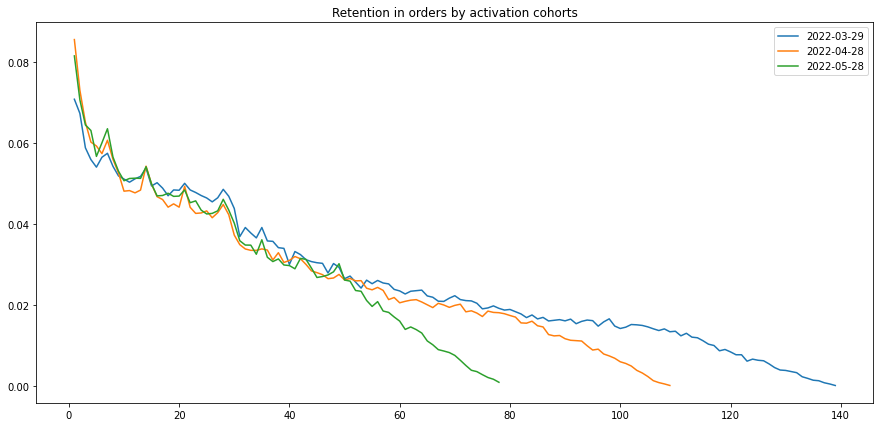

In [ ]:
ret_df = data[mask].groupby(['relative_day', 'activation_week'])['customer_id'].nunique().unstack()
ret_df = ret_df.loc[1:]

tmp = data[mask].groupby(['activation_week'])['customer_id'].nunique()
ret_df = ret_df / tmp

plt.figure(figsize=(15, 7))
for c in ret_df.columns:
    plt.plot(ret_df.index, ret_df[c], label=c.date())
plt.legend()
plt.title('Retention in orders by activation cohorts')

In [161]:
data['created_month'] = data['created_at'].dt.floor('30D')
data['nan_eta'] = data['eta'].isna()
data['nan_rta'] = data['rta'].isna()

In [159]:
data.groupby('created_month')['nan_rta'].mean().tail(10)

created_month
2021-10-30 00:00:00+00:00    0.157553
2021-11-29 00:00:00+00:00    0.161716
2021-12-29 00:00:00+00:00    0.167231
2022-01-28 00:00:00+00:00    0.192846
2022-02-27 00:00:00+00:00    0.202382
2022-03-29 00:00:00+00:00    0.225786
2022-04-28 00:00:00+00:00    0.202708
2022-05-28 00:00:00+00:00    0.187305
2022-06-27 00:00:00+00:00    0.187469
2022-07-27 00:00:00+00:00    0.203689
Name: nan_rta, dtype: float64

In [218]:
data['distance_bin'] = pd.cut(data['distance'], (0, 6, np.inf))

Text(0.5, 1.0, 'Retention in orders by activation cohorts')

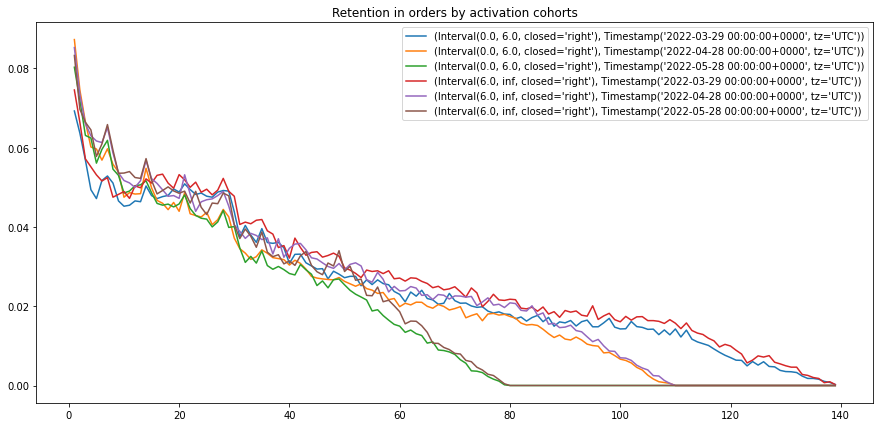

In [219]:
ret_df = data[mask].groupby(['relative_day', 'activation_week', 'distance_bin'])['customer_id'].nunique().unstack().unstack()
ret_df = ret_df / ret_df.max()
ret_df = ret_df[ret_df.index > 0]

plt.figure(figsize=(15, 7))
for c in ret_df.columns:
    plt.plot(ret_df.index, ret_df[c], label=c)
plt.legend()
plt.title('Retention in orders by activation cohorts')

<AxesSubplot:>

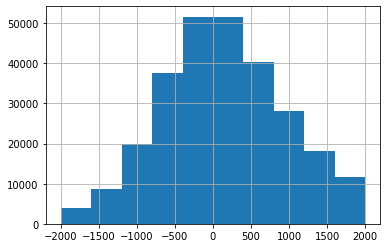

In [224]:
m = (activations['delay'] > -2000) & (activations['delay'] < 2000)
activations[m]['delay'].hist()

Text(0.5, 1.0, 'Retention in orders by activation cohorts')

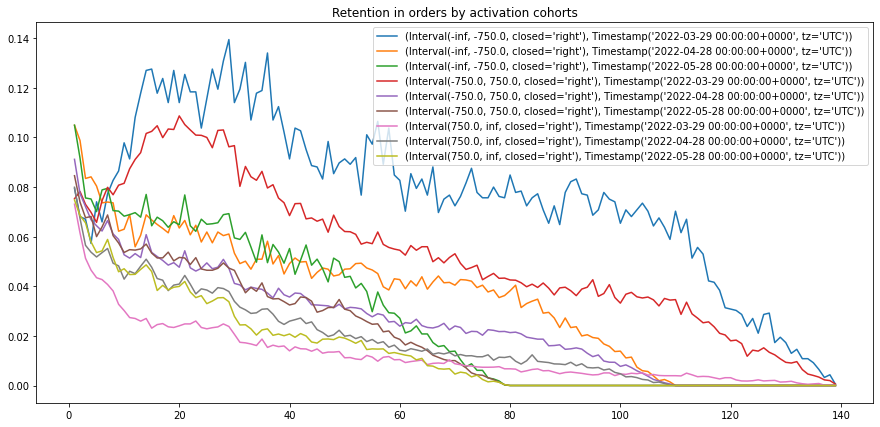

In [225]:
data['delay_bin'] = pd.cut(data['delay'], (-np.inf, -750, 750, np.inf))

ret_df = data[mask].groupby(['relative_day', 'activation_week', 'delay_bin'])['customer_id'].nunique().unstack().unstack()
ret_df = ret_df / ret_df.max()
ret_df = ret_df[ret_df.index > 0]

plt.figure(figsize=(15, 7))
for c in ret_df.columns:
    plt.plot(ret_df.index, ret_df[c], label=c)
plt.legend()
plt.title('Retention in orders by activation cohorts')

In [203]:
ret_df.columns[0].type

AttributeError: 'tuple' object has no attribute 'type'